### Experiments with training different dataset 

Goal is to see if training on high freq leads to better performance on low freq dataset than training on low freq dataset for high freq data  

8/19

Imports

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [2]:
save = False

Only for python script: uncomment if running on cluster

In [3]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [4]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [7]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        # The number of different frequency components will be between 1 and 10
        num_freqs = torch.randint(1, 10, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes (between 0 and 1)
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [8]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 10)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 6, 10)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [9]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

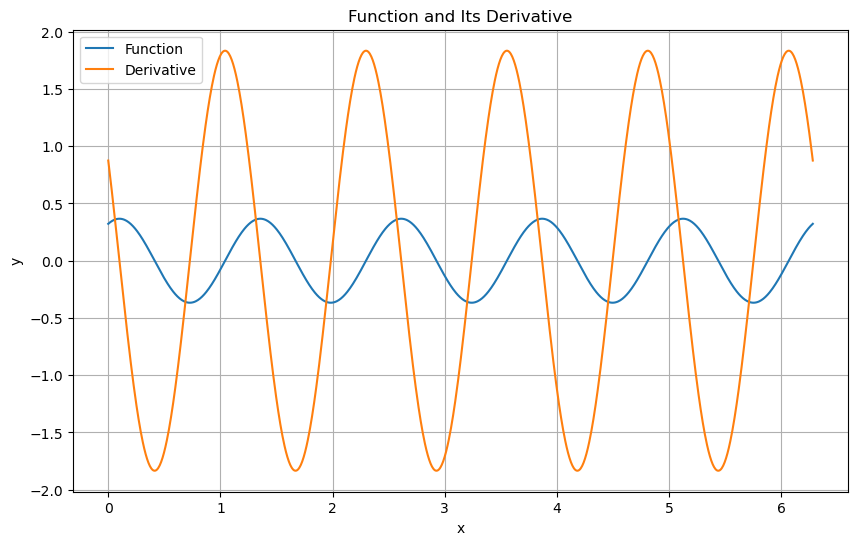

In [10]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

Stopped here

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [12]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [13]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

## Miscellaneous plotting functions

In [14]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [15]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [16]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Create models

In [20]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

## Tests to see model output frequencies

In [31]:
def plot_frequencies(function, derivative=None, residue=None, model=None):
    x = np.linspace(0, 2*np.pi, 1000)
    first_function = function

    N = 1000

    # frequencies = torch.fft.fftfreq(N, 2*np.pi/N) * 2*np.pi
    frequencies = np.fft.fftfreq(N, 1/N)
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    F = np.fft.fft(first_function.detach().numpy())
    magnitudes = np.abs(F) / N
    positive_magnitudes = magnitudes[positive_freq_indices]

    if residue:
        model.eval()
        F_derivative = np.fft.fft(derivative.detach().numpy())
        F_output = np.fft.fft(model(function.unsqueeze(0)).squeeze().detach().numpy())

        F_residue = F_derivative - F_output
        magnitudes = np.abs(F_residue) / N
        print("residue")


    # Plotting the frequency spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(positive_freqs, positive_magnitudes, label='Function')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum of the Function')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 20)  # Adjust this based on your frequency range
    print(f"lim: 18")
    plt.show()


lim: 18


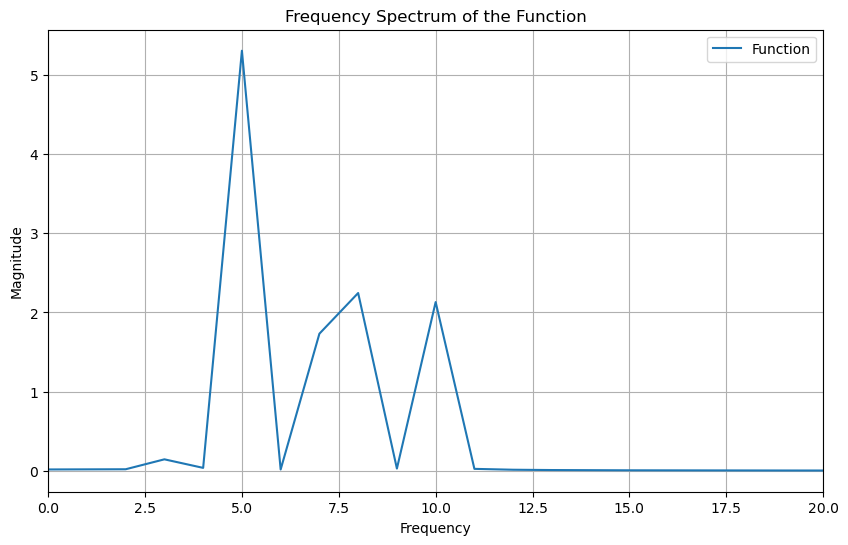

In [32]:
a = np.random.randint(0, 32)
function = test_dataset_g[a][0]
derivative = test_dataset_g[a][1]

plot_frequencies(derivative)

In [33]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)
L3ModelK3.load_state_dict(torch.load('../../models/3_layers.pth'))

L3ModelK3_untrained = SimpleCNN(n_layers=3, kernel_size=3)

lim: 18


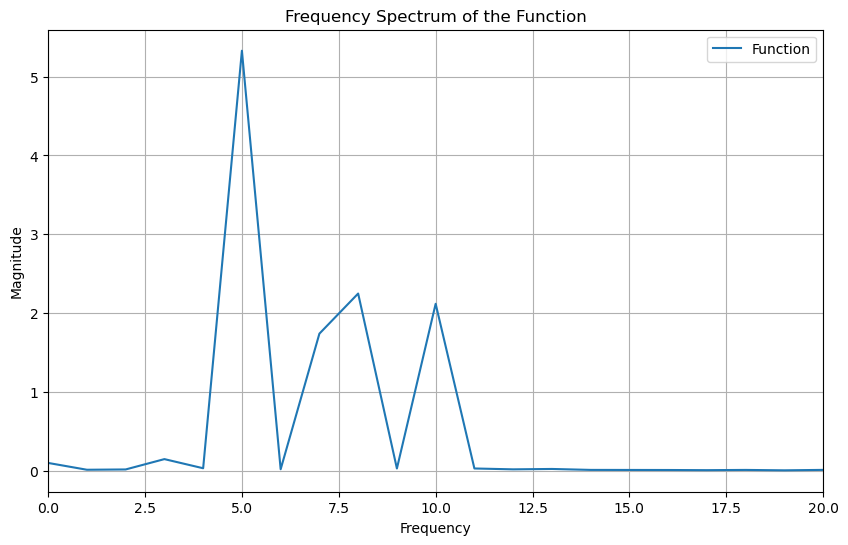

In [34]:
function1 = function.unsqueeze(0)
output = L3ModelK3(function1).squeeze()
plot_frequencies(output)

residue
lim: 18


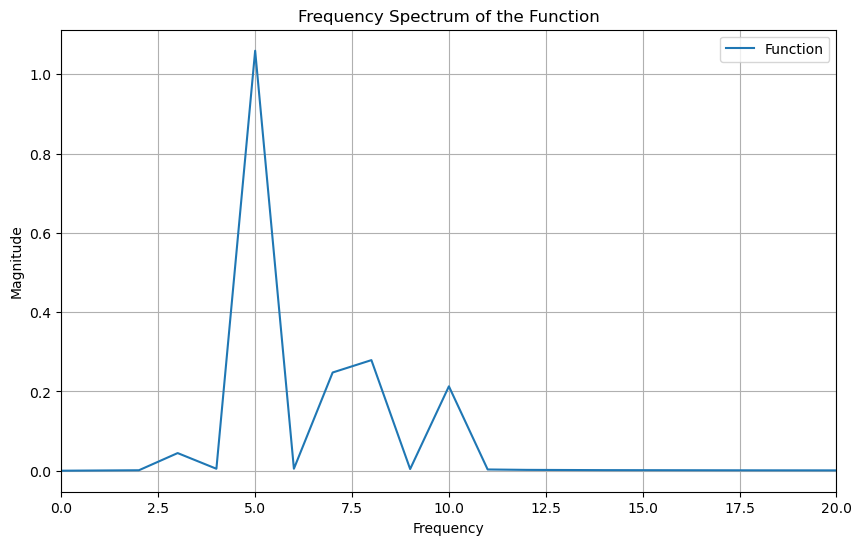

In [35]:
plot_frequencies(function=function, derivative=derivative, residue=True, model=L3ModelK3)

lim: 18


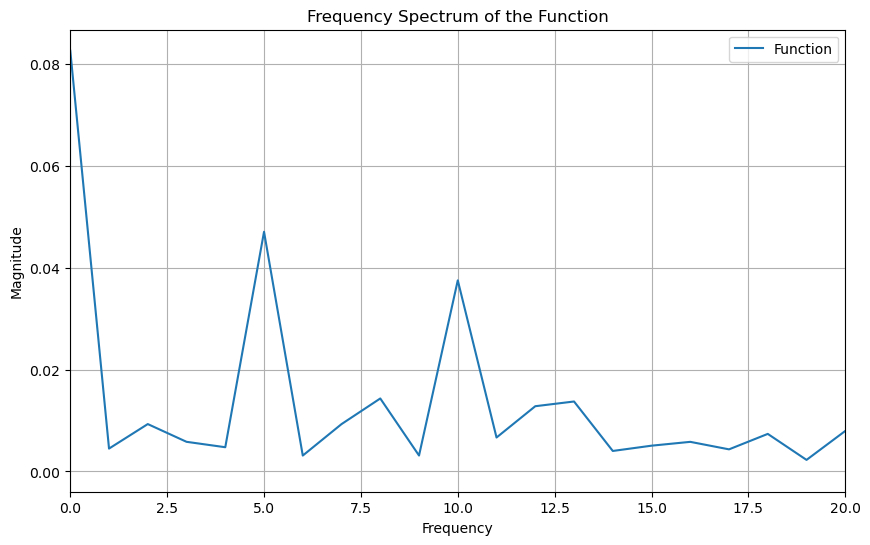

In [37]:
# This is incorrect, since we want fourier(deriv) - fourier(output) not deriv - output
plot_frequencies(derivative - output)

## Function to train model

In [38]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None, nmse=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define a new loss function that can use NMSE
    def criterion2(target, output, nmse=None):
        mse = torch.mean((target - output) ** 2)
        if nmse:
            mse = mse / torch.mean(target ** 2)
        
        return mse

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion2(outputs, batch_derivatives, nmse=True)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion2(test_outputs, b_test_derivatives, nmse=True)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')

    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

## Metric functions

In [39]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

In [40]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

In [41]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Plot results

In [42]:
def plot_all_outputs(model, model_name):
    plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

## Color map plots

In [87]:
def compute_fft_and_max_freq(dataloader, deriv=False, model=None, residue=False):
    fft_amplitudes = []
    max_frequencies = []
    T = 2 * torch.pi
    N = 1000

    # The spacing is T / N, i.e. 2pi/1000, but since we interpret f(x)=sin(5x) to
    # have a frequency of 5 over the domain x=[0,2pi], then we scale up by 2pi 
    # to get the unit cycle back to 1
    frequencies = torch.fft.fftfreq(N, T / N) * T
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    plot_type = ''

    # Iterate over each batch
    for functions, derivatives in dataloader:  # Note that derivatives are ignored in this loop
        
        if deriv and not model and not residue: # If you only want the derivative
            functions = derivatives
            F = torch.fft.fft(functions)
            print("Showing ground truth derivative")
            plot_type = "ground truth u_g'"
            
            
        elif not deriv and model and not residue: # If you only want the model output
            functions = model(functions.unsqueeze(1)).squeeze()
            F = torch.fft.fft(functions)
            print("Showing model output")
            plot_type = 'model output f(u_g)'

            # output = model(functions)
            
            # output = output.squeeze()
            # functions = output # set this so that the FFTs can be computed in the next line
        
        elif residue and model: # If you only want the residue
            
            functions = functions.unsqueeze(1)
            outputs = model(functions).squeeze()
            F_outputs = torch.fft.fft(outputs)

            F_derivatives = torch.fft.fft(derivatives)

            residues = F_derivatives - F_outputs
            
            # print(f"shape of F_derivaives: {F_derivatives.shape}")
            # normalizing = F_derivatives.norm(p=2, dim=1, keepdim=True) ** 2 / F_derivatives.shape[1]
            # print(f"shape of normalizing: {normalizing}")
            # residues = residues / normalizing

            print("Showing residues")
            plot_type = 'spectral error'
            F = residues
            # print(f"F is: {F}")

        else:
            print("Showing u_g")
            plot_type = 'ground truth u_g'
            F = torch.fft.fft(functions)

        # else: # If you only want the original function u_g
        magnitudes = torch.abs(F) / N

        # Consider only positive frequencies
        positive_magnitudes = magnitudes[:, positive_freq_indices]

        fft_amplitudes.append(positive_magnitudes)
        
        # Maximum frequency based on the highest amplitude for each function in the batch
        max_indices = torch.argmax(positive_magnitudes, dim=1)
        batch_max_freqs = positive_freqs[max_indices]
        max_frequencies.extend(batch_max_freqs)

    return torch.vstack(fft_amplitudes), torch.tensor(max_frequencies), positive_freqs, plot_type

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xmin=0, xmax=0, sort=True):
    fft_amplitudes = fft_amplitudes.detach().numpy()
    max_frequencies = max_frequencies.detach().numpy()
    freqs = freqs.detach().numpy()
    
    if sort:
    # Sort functions by dominant frequency
        sorted_indices = np.argsort(-max_frequencies)  # Sort in descending order
        sorted_fft = fft_amplitudes[sorted_indices]
    else:
        sorted_fft = fft_amplitudes

    plt.figure(figsize=(10, 6))
    im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)],\
        interpolation='nearest')

    plt.colorbar(im, label='Amplitude')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim([xmin, xmax])
    plt.show()


In [88]:
# Default is u_g
# This function plots the heatmaps for all frequencies for the test datlaoaders
def plot_heatmaps(deriv=None, model=None, residue=False, label=None, all=True, sort=True, epoch=None):
    if all: # Plot all three datasets
        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_l,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'Low freq {label} at epoch {epoch}', xmin=0, xmax=6, sort=sort)

        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label} at epoch {epoch}', xmin=0, xmax=11, sort=sort)

        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_h,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'High freq {label} at epoch {epoch}', xmin=6, xmax=11, sort=sort)

    else: # Plot only the general frequency dataset
        fft_amplitudes, max_frequencies, freqs, label = compute_fft_and_max_freq(test_dataloader_g,\
            deriv=deriv, model=model, residue=residue)
        plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type=f'General freq {label} at epoch {epoch}', xmin=0, xmax=11, sort=sort)


In [94]:
train_losses, test_losses = [], []

def model_training_plots(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None, nmse=None,\
        deriv=None, residue=False, lr=1e-3, heatmap=True, sort=True):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = lr

    optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion = nn.MSELoss()
    
    num_plots = split_freq
    split_freq = num_epochs // split_freq
    print(split_freq)

    plot_heatmaps(model=model, label=f'first', all=False)
    plt.show()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0


        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)
                

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        # If iteration reached, then plot the colormap once
        if heatmap:
            if (epoch) % split_freq == 0:
                print(f"Plotting the colormap once at iteration {epoch}")
                label = epoch // split_freq

                l, g, h = print_and_store_metrics(model)
                low_freq_nmses.append(l)
                general_freq_nmses.append(g)
                high_freq_nmses.append(h)
                epoch_list.append(epoch)

                plot_heatmaps(model=model, label=f'{label}', all=False,\
                    deriv=deriv, residue=residue, sort=sort, epoch=epoch)

                plt.show()

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')

    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

Showing residues
Showing residues
Showing residues


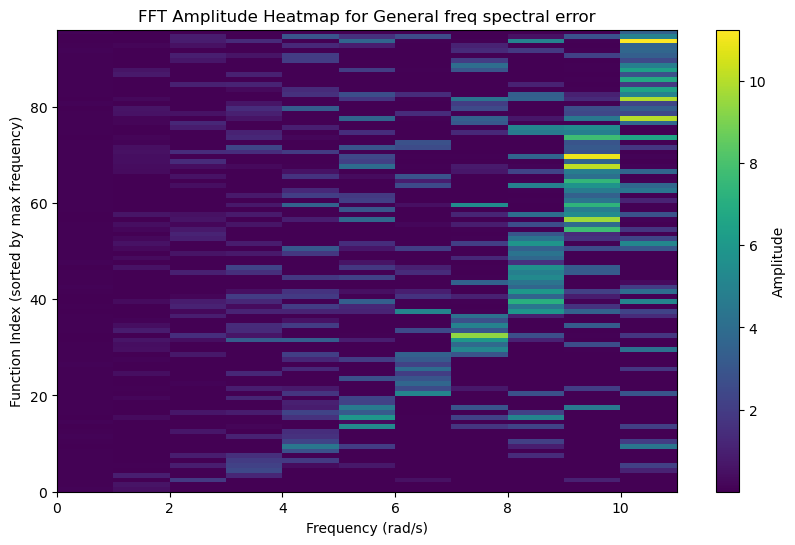

In [92]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)
plot_heatmaps(model=L3ModelK3_low, residue=True, all=False, sort=True)


**The above looks a lot like the trained model output or true derivative**

50
Showing model output
Showing model output
Showing model output


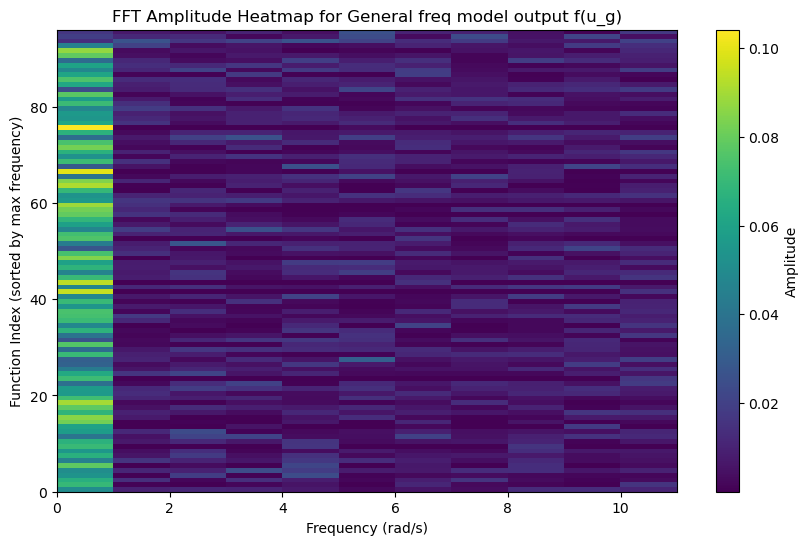

Epoch [1/500], Train Loss: 18.3462, Test Loss: 19.8396
Plotting the colormap once at iteration 0
Showing model output
Showing model output
Showing model output


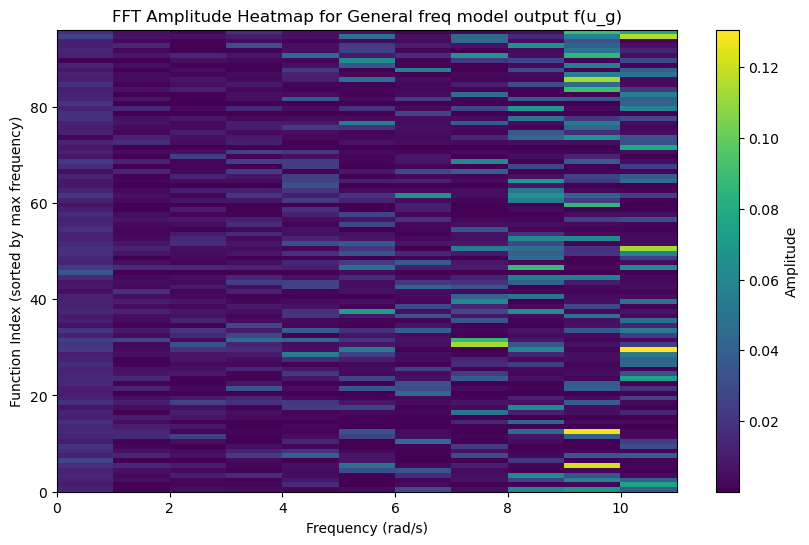

Epoch [2/500], Train Loss: 17.6501, Test Loss: 19.0480
Epoch [3/500], Train Loss: 16.5433, Test Loss: 17.5647
Epoch [4/500], Train Loss: 14.8638, Test Loss: 15.2394
Epoch [5/500], Train Loss: 12.4022, Test Loss: 12.0160
Epoch [6/500], Train Loss: 9.1487, Test Loss: 8.4067
Epoch [7/500], Train Loss: 6.4017, Test Loss: 5.4065
Epoch [8/500], Train Loss: 4.1229, Test Loss: 3.7302
Epoch [9/500], Train Loss: 2.9940, Test Loss: 2.9168
Epoch [10/500], Train Loss: 2.5059, Test Loss: 2.6101
Epoch [11/500], Train Loss: 2.2536, Test Loss: 2.3233
Epoch [12/500], Train Loss: 2.1435, Test Loss: 2.2233
Epoch [13/500], Train Loss: 2.0403, Test Loss: 2.0523
Epoch [14/500], Train Loss: 1.8909, Test Loss: 1.9266
Epoch [15/500], Train Loss: 1.7487, Test Loss: 1.8010
Epoch [16/500], Train Loss: 1.6366, Test Loss: 1.6932
Epoch [17/500], Train Loss: 1.5601, Test Loss: 1.5828
Epoch [18/500], Train Loss: 1.4257, Test Loss: 1.4833
Epoch [19/500], Train Loss: 1.3301, Test Loss: 1.3838
Epoch [20/500], Train Loss: 

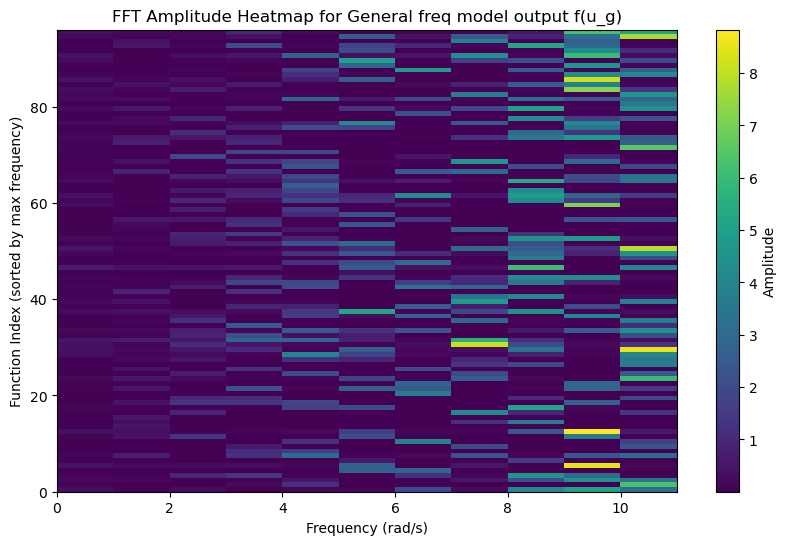

Epoch [52/500], Train Loss: 0.2566, Test Loss: 0.2524
Epoch [53/500], Train Loss: 0.2436, Test Loss: 0.2421
Epoch [54/500], Train Loss: 0.2276, Test Loss: 0.2355
Epoch [55/500], Train Loss: 0.2316, Test Loss: 0.2308
Epoch [56/500], Train Loss: 0.2281, Test Loss: 0.2249
Epoch [57/500], Train Loss: 0.2203, Test Loss: 0.2206
Epoch [58/500], Train Loss: 0.2174, Test Loss: 0.2160
Epoch [59/500], Train Loss: 0.2122, Test Loss: 0.2129
Epoch [60/500], Train Loss: 0.2060, Test Loss: 0.2091
Epoch [61/500], Train Loss: 0.2069, Test Loss: 0.2053
Epoch [62/500], Train Loss: 0.2160, Test Loss: 0.2114
Epoch [63/500], Train Loss: 0.2094, Test Loss: 0.2149
Epoch [64/500], Train Loss: 0.2020, Test Loss: 0.1987
Epoch [65/500], Train Loss: 0.1921, Test Loss: 0.1910
Epoch [66/500], Train Loss: 0.1850, Test Loss: 0.1861
Epoch [67/500], Train Loss: 0.1656, Test Loss: 0.1823
Epoch [68/500], Train Loss: 0.1779, Test Loss: 0.1796
Epoch [69/500], Train Loss: 0.1816, Test Loss: 0.1961
Epoch [70/500], Train Loss: 

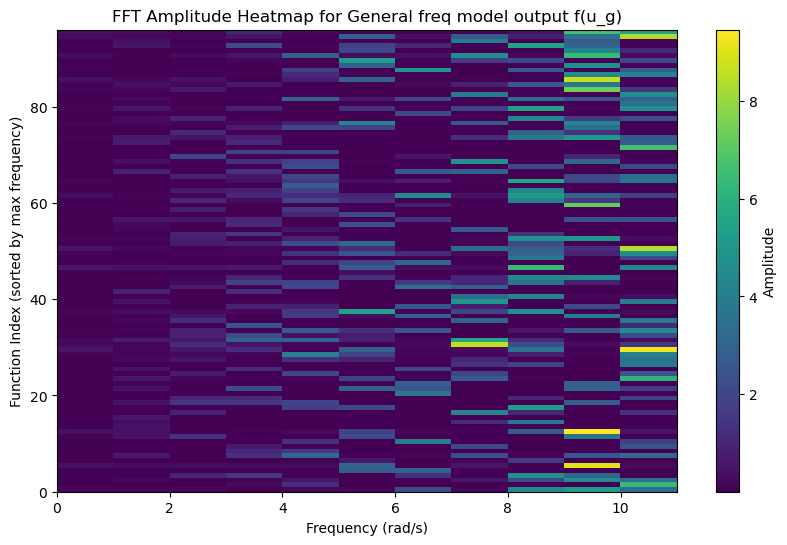

Epoch [102/500], Train Loss: 0.1035, Test Loss: 0.1041
Epoch [103/500], Train Loss: 0.1034, Test Loss: 0.1047
Epoch [104/500], Train Loss: 0.1011, Test Loss: 0.1031
Epoch [105/500], Train Loss: 0.0960, Test Loss: 0.1001
Epoch [106/500], Train Loss: 0.0998, Test Loss: 0.0978
Epoch [107/500], Train Loss: 0.1009, Test Loss: 0.0981
Epoch [108/500], Train Loss: 0.0964, Test Loss: 0.0991
Epoch [109/500], Train Loss: 0.0953, Test Loss: 0.0959
Epoch [110/500], Train Loss: 0.1023, Test Loss: 0.0933
Epoch [111/500], Train Loss: 0.0978, Test Loss: 0.0922
Epoch [112/500], Train Loss: 0.0921, Test Loss: 0.0906
Epoch [113/500], Train Loss: 0.0882, Test Loss: 0.0890
Epoch [114/500], Train Loss: 0.0831, Test Loss: 0.0880
Epoch [115/500], Train Loss: 0.0854, Test Loss: 0.0870
Epoch [116/500], Train Loss: 0.0763, Test Loss: 0.0857
Epoch [117/500], Train Loss: 0.0797, Test Loss: 0.0846
Epoch [118/500], Train Loss: 0.0834, Test Loss: 0.0957
Epoch [119/500], Train Loss: 0.0982, Test Loss: 0.0831
Epoch [120

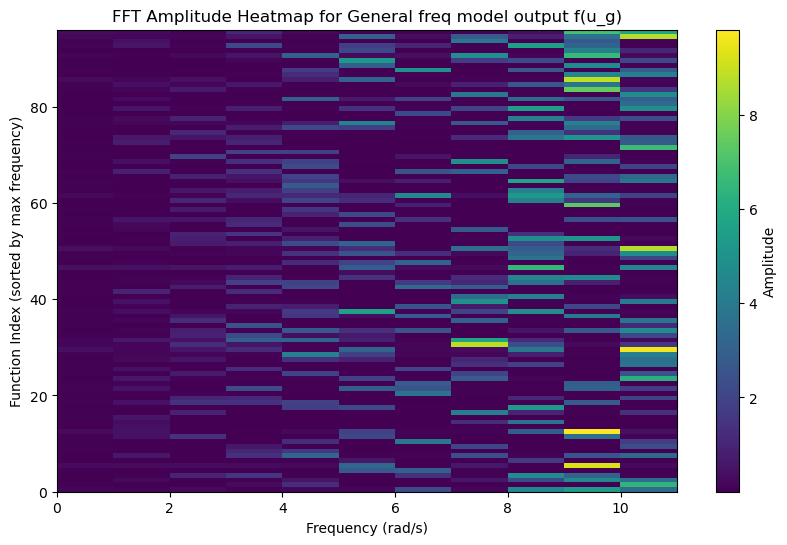

Epoch [152/500], Train Loss: 0.0680, Test Loss: 0.0728
Epoch [153/500], Train Loss: 0.0643, Test Loss: 0.0616
Epoch [154/500], Train Loss: 0.0585, Test Loss: 0.0608
Epoch [155/500], Train Loss: 0.0576, Test Loss: 0.0608
Epoch [156/500], Train Loss: 0.0572, Test Loss: 0.0612
Epoch [157/500], Train Loss: 0.0577, Test Loss: 0.0633
Epoch [158/500], Train Loss: 0.0586, Test Loss: 0.0641
Epoch [159/500], Train Loss: 0.0738, Test Loss: 0.4038
Epoch [160/500], Train Loss: 0.2157, Test Loss: 0.0977
Epoch [161/500], Train Loss: 0.1139, Test Loss: 0.0692
Epoch [162/500], Train Loss: 0.0811, Test Loss: 0.0595
Epoch [163/500], Train Loss: 0.0605, Test Loss: 0.0637
Epoch [164/500], Train Loss: 0.0564, Test Loss: 0.0601
Epoch [165/500], Train Loss: 0.0532, Test Loss: 0.0577
Epoch [166/500], Train Loss: 0.0500, Test Loss: 0.0570
Epoch [167/500], Train Loss: 0.0514, Test Loss: 0.0558
Epoch [168/500], Train Loss: 0.0517, Test Loss: 0.0551
Epoch [169/500], Train Loss: 0.0509, Test Loss: 0.0555
Epoch [170

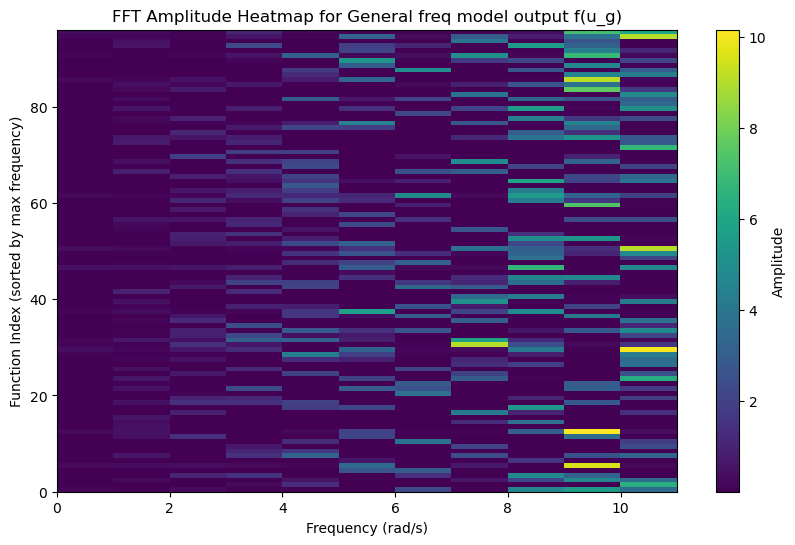

Epoch [202/500], Train Loss: 0.0391, Test Loss: 0.0436
Epoch [203/500], Train Loss: 0.0396, Test Loss: 0.0435
Epoch [204/500], Train Loss: 0.0394, Test Loss: 0.0439
Epoch [205/500], Train Loss: 0.0396, Test Loss: 0.0419
Epoch [206/500], Train Loss: 0.0386, Test Loss: 0.0459
Epoch [207/500], Train Loss: 0.0401, Test Loss: 0.0493
Epoch [208/500], Train Loss: 0.0406, Test Loss: 0.0495
Epoch [209/500], Train Loss: 0.0394, Test Loss: 0.0418
Epoch [210/500], Train Loss: 0.0382, Test Loss: 0.0435
Epoch [211/500], Train Loss: 0.0376, Test Loss: 0.0465
Epoch [212/500], Train Loss: 0.0427, Test Loss: 0.0561
Epoch [213/500], Train Loss: 0.0465, Test Loss: 0.0493
Epoch [214/500], Train Loss: 0.0432, Test Loss: 0.0406
Epoch [215/500], Train Loss: 0.0454, Test Loss: 0.1314
Epoch [216/500], Train Loss: 0.1101, Test Loss: 0.1025
Epoch [217/500], Train Loss: 0.0640, Test Loss: 0.0441
Epoch [218/500], Train Loss: 0.0403, Test Loss: 0.0417
Epoch [219/500], Train Loss: 0.0399, Test Loss: 0.0508
Epoch [220

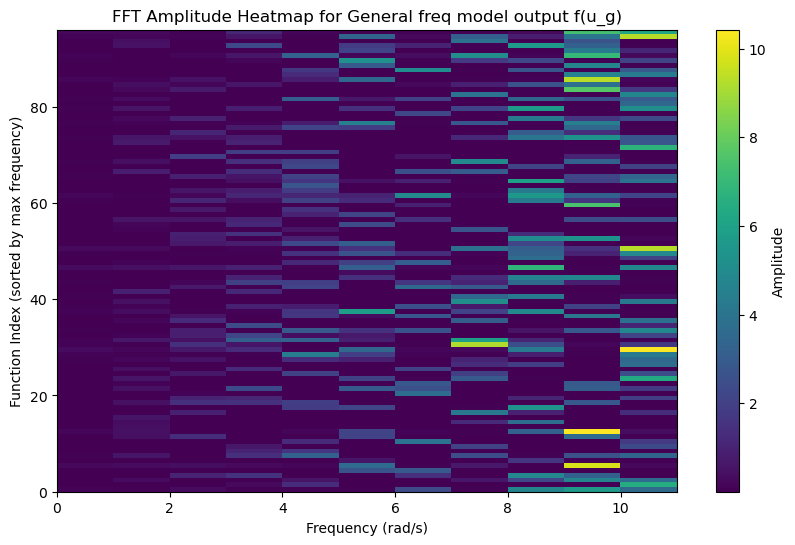

Epoch [252/500], Train Loss: 0.0297, Test Loss: 0.0366
Epoch [253/500], Train Loss: 0.0348, Test Loss: 0.0384
Epoch [254/500], Train Loss: 0.0295, Test Loss: 0.0360
Epoch [255/500], Train Loss: 0.0350, Test Loss: 0.0376
Epoch [256/500], Train Loss: 0.0846, Test Loss: 0.0665
Epoch [257/500], Train Loss: 0.0688, Test Loss: 0.0838
Epoch [258/500], Train Loss: 0.0706, Test Loss: 0.0941
Epoch [259/500], Train Loss: 0.0636, Test Loss: 0.0678
Epoch [260/500], Train Loss: 0.0806, Test Loss: 0.2563
Epoch [261/500], Train Loss: 0.1325, Test Loss: 0.1876
Epoch [262/500], Train Loss: 0.0836, Test Loss: 0.0374
Epoch [263/500], Train Loss: 0.0675, Test Loss: 0.0763
Epoch [264/500], Train Loss: 0.0959, Test Loss: 0.0913
Epoch [265/500], Train Loss: 0.0567, Test Loss: 0.0673
Epoch [266/500], Train Loss: 0.0342, Test Loss: 0.0383
Epoch [267/500], Train Loss: 0.0318, Test Loss: 0.0348
Epoch [268/500], Train Loss: 0.0302, Test Loss: 0.0353
Epoch [269/500], Train Loss: 0.0257, Test Loss: 0.0333
Epoch [270

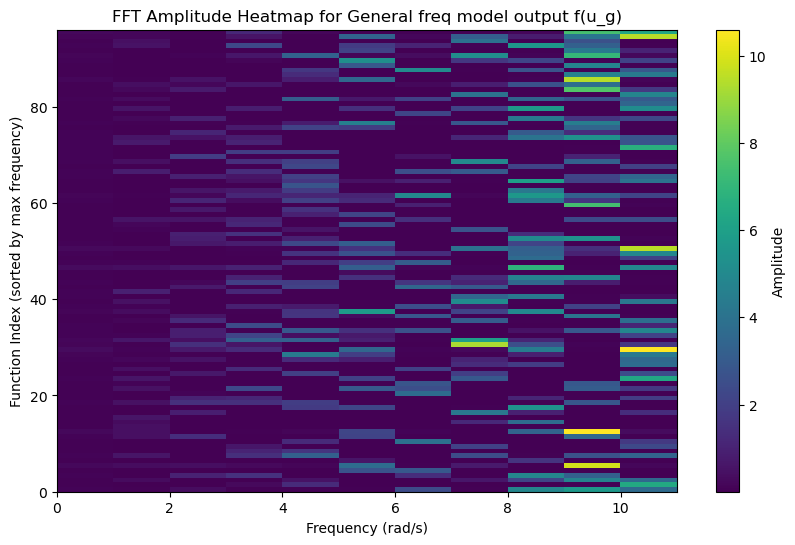

Epoch [302/500], Train Loss: 0.0267, Test Loss: 0.0273
Epoch [303/500], Train Loss: 0.0251, Test Loss: 0.0263
Epoch [304/500], Train Loss: 0.0237, Test Loss: 0.0303
Epoch [305/500], Train Loss: 0.0250, Test Loss: 0.0282
Epoch [306/500], Train Loss: 0.0312, Test Loss: 0.0351
Epoch [307/500], Train Loss: 0.0253, Test Loss: 0.0371
Epoch [308/500], Train Loss: 0.0259, Test Loss: 0.0280
Epoch [309/500], Train Loss: 0.0223, Test Loss: 0.0284
Epoch [310/500], Train Loss: 0.0229, Test Loss: 0.0262
Epoch [311/500], Train Loss: 0.0265, Test Loss: 0.0374
Epoch [312/500], Train Loss: 0.0247, Test Loss: 0.0256
Epoch [313/500], Train Loss: 0.0280, Test Loss: 0.0382
Epoch [314/500], Train Loss: 0.0284, Test Loss: 0.0256
Epoch [315/500], Train Loss: 0.0278, Test Loss: 0.0325
Epoch [316/500], Train Loss: 0.0227, Test Loss: 0.0253
Epoch [317/500], Train Loss: 0.0214, Test Loss: 0.0251
Epoch [318/500], Train Loss: 0.0232, Test Loss: 0.0302
Epoch [319/500], Train Loss: 0.0231, Test Loss: 0.0262
Epoch [320

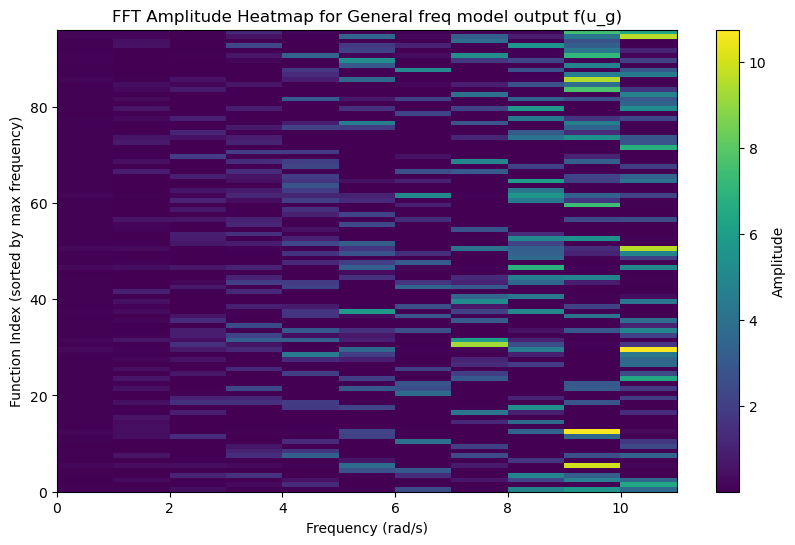

Epoch [352/500], Train Loss: 0.0217, Test Loss: 0.0442
Epoch [353/500], Train Loss: 0.0257, Test Loss: 0.0414
Epoch [354/500], Train Loss: 0.0410, Test Loss: 0.0525
Epoch [355/500], Train Loss: 0.0381, Test Loss: 0.0227
Epoch [356/500], Train Loss: 0.0324, Test Loss: 0.0319
Epoch [357/500], Train Loss: 0.0440, Test Loss: 0.0819
Epoch [358/500], Train Loss: 0.0627, Test Loss: 0.3238
Epoch [359/500], Train Loss: 0.1761, Test Loss: 0.3227
Epoch [360/500], Train Loss: 0.1428, Test Loss: 0.0293
Epoch [361/500], Train Loss: 0.0489, Test Loss: 0.0358
Epoch [362/500], Train Loss: 0.0462, Test Loss: 0.0412
Epoch [363/500], Train Loss: 0.0441, Test Loss: 0.0269
Epoch [364/500], Train Loss: 0.0228, Test Loss: 0.0211
Epoch [365/500], Train Loss: 0.0186, Test Loss: 0.0208
Epoch [366/500], Train Loss: 0.0177, Test Loss: 0.0205
Epoch [367/500], Train Loss: 0.0165, Test Loss: 0.0196
Epoch [368/500], Train Loss: 0.0163, Test Loss: 0.0184
Epoch [369/500], Train Loss: 0.0156, Test Loss: 0.0183
Epoch [370

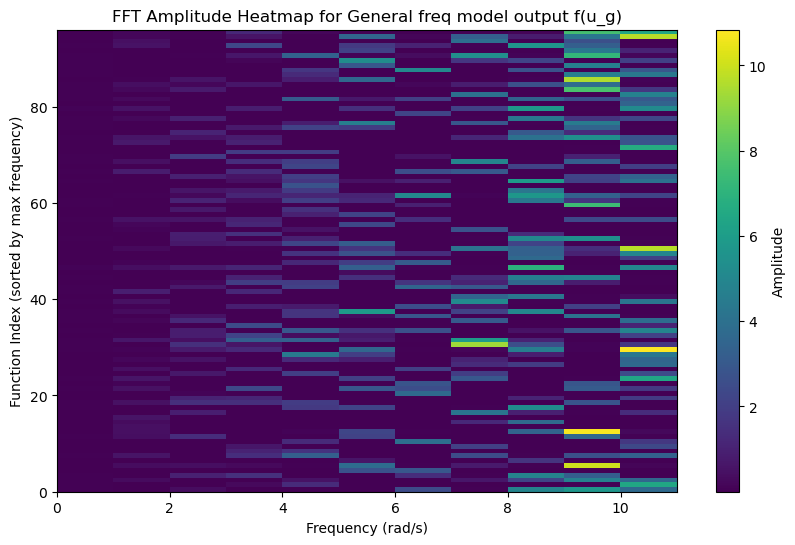

Epoch [402/500], Train Loss: 0.0294, Test Loss: 0.0175
Epoch [403/500], Train Loss: 0.0207, Test Loss: 0.0156
Epoch [404/500], Train Loss: 0.0163, Test Loss: 0.0154
Epoch [405/500], Train Loss: 0.0148, Test Loss: 0.0160
Epoch [406/500], Train Loss: 0.0148, Test Loss: 0.0164
Epoch [407/500], Train Loss: 0.0131, Test Loss: 0.0153
Epoch [408/500], Train Loss: 0.0131, Test Loss: 0.0150
Epoch [409/500], Train Loss: 0.0125, Test Loss: 0.0152
Epoch [410/500], Train Loss: 0.0126, Test Loss: 0.0152
Epoch [411/500], Train Loss: 0.0131, Test Loss: 0.0149
Epoch [412/500], Train Loss: 0.0130, Test Loss: 0.0147
Epoch [413/500], Train Loss: 0.0128, Test Loss: 0.0149
Epoch [414/500], Train Loss: 0.0128, Test Loss: 0.0146
Epoch [415/500], Train Loss: 0.0131, Test Loss: 0.0148
Epoch [416/500], Train Loss: 0.0130, Test Loss: 0.0150
Epoch [417/500], Train Loss: 0.0129, Test Loss: 0.0146
Epoch [418/500], Train Loss: 0.0129, Test Loss: 0.0153
Epoch [419/500], Train Loss: 0.0139, Test Loss: 0.0168
Epoch [420

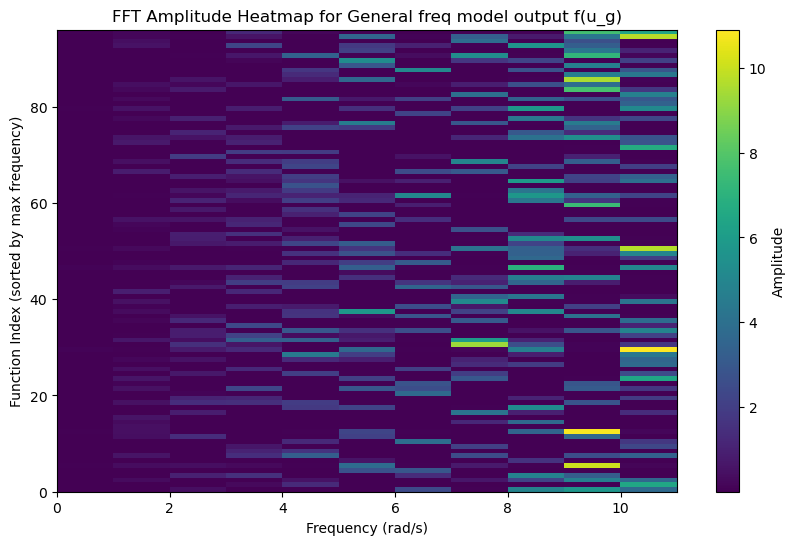

Epoch [452/500], Train Loss: 0.0111, Test Loss: 0.0119
Epoch [453/500], Train Loss: 0.0138, Test Loss: 0.0120
Epoch [454/500], Train Loss: 0.0404, Test Loss: 0.0418
Epoch [455/500], Train Loss: 0.1194, Test Loss: 0.0336
Epoch [456/500], Train Loss: 0.0461, Test Loss: 0.0231
Epoch [457/500], Train Loss: 0.0175, Test Loss: 0.0117
Epoch [458/500], Train Loss: 0.0173, Test Loss: 0.0116
Epoch [459/500], Train Loss: 0.0144, Test Loss: 0.0159
Epoch [460/500], Train Loss: 0.0145, Test Loss: 0.0110
Epoch [461/500], Train Loss: 0.0126, Test Loss: 0.0158
Epoch [462/500], Train Loss: 0.0109, Test Loss: 0.0138
Epoch [463/500], Train Loss: 0.0104, Test Loss: 0.0119
Epoch [464/500], Train Loss: 0.0099, Test Loss: 0.0107
Epoch [465/500], Train Loss: 0.0090, Test Loss: 0.0103
Epoch [466/500], Train Loss: 0.0089, Test Loss: 0.0103
Epoch [467/500], Train Loss: 0.0088, Test Loss: 0.0101
Epoch [468/500], Train Loss: 0.0089, Test Loss: 0.0100
Epoch [469/500], Train Loss: 0.0084, Test Loss: 0.0101
Epoch [470

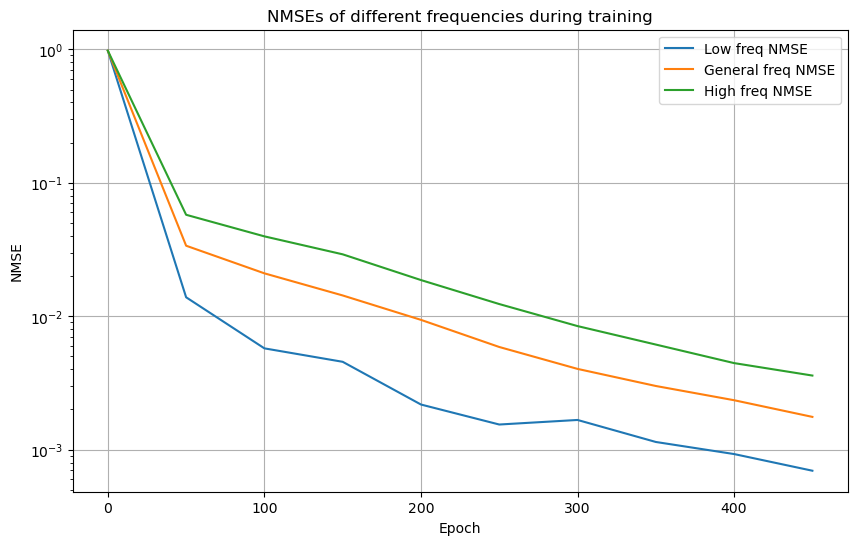

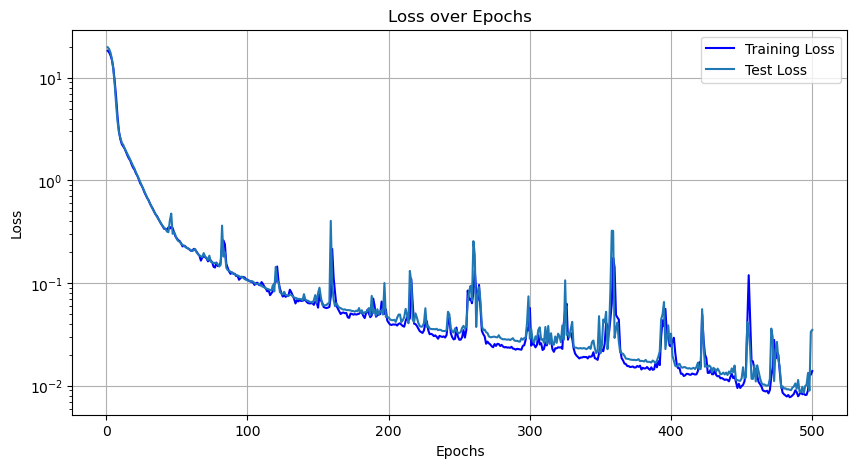

In [93]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training_plots(L3ModelK3_low, train_dataloader_l, test_dataloader_l,\
    num_epochs=500, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first', residue=False, lr=1e-3, sort=False)
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

## Experiments with training on different datasets

3 layers, kernel size 3

### Training on low frequency dataset only

In [ ]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

# train_losses, test_losses = model_training(L3ModelK3_low, train_dataloader_l, test_dataloader_l,\
#     num_epochs=2000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first', nmse=True)
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [ ]:
print_metrics(L3ModelK3_low)

NMSE over low freq test functions: 0.9994839429855347
NMSE over general freq test functions: 0.9992063641548157
NMSE over high freq test functions: 0.9992488622665405


In [ ]:
(0.08218340575695038 - 0.001168005052022636) / 0.001168005052022636

69.36220058691806